In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as T

In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor

2024-06-03 15:55:29.431906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 15:55:29.432011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 15:55:29.562936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import classification_report

In [5]:
# Define a custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load dataset paths and labels
def load_dataset(data_dir):
    image_paths = []
    labels = []
    class_names = os.listdir(data_dir)
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])
    return image_paths, labels

data_dir = '/kaggle/input/chest-dataset-complement/complement'  # Replace with your dataset path
image_paths, labels = load_dataset(data_dir)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)

# Data augmentation and normalization for training
transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Normalization for validation and test
transform_val_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = ImageDataset(train_paths, train_labels, transform=transform_train)
val_dataset = ImageDataset(val_paths, val_labels, transform=transform_val_test)
test_dataset = ImageDataset(test_paths, test_labels, transform=transform_val_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
class_namess = os.listdir(data_dir)

In [7]:
class_namess

['pneumonia', 'normal', 'lung_opacity', 'covid']

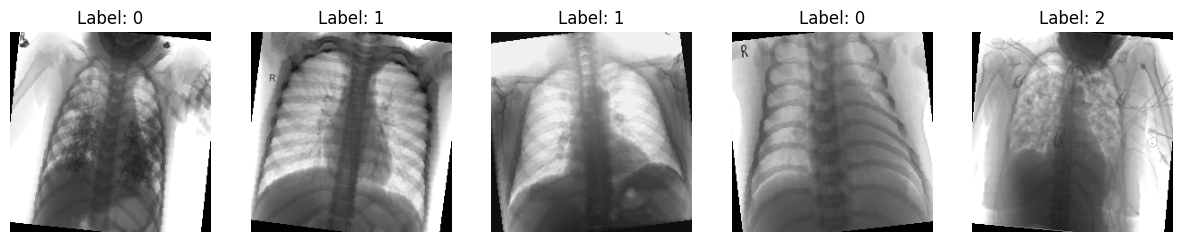

In [8]:
# Verify data loading
def verify_data_loader(data_loader, num_samples=5):
    import matplotlib.pyplot as plt

    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for idx in range(num_samples):
        ax = axes[idx]
        img = images[idx].numpy().transpose(1, 2, 0)
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        ax.imshow(img)
        ax.set_title(f'Label: {labels[idx].item()}')
        ax.axis('off')

    plt.show()

# Verify training data loader
verify_data_loader(train_loader)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/25], Train Loss: 0.3306, Val Loss: 0.2231, Train Accuracy: 0.8800, Val Accuracy: 0.9193
Saved the best model at epoch 1
Epoch [2/25], Train Loss: 0.1744, Val Loss: 0.2135, Train Accuracy: 0.9393, Val Accuracy: 0.9170
Saved the best model at epoch 2
Epoch [3/25], Train Loss: 0.1396, Val Loss: 0.2040, Train Accuracy: 0.9512, Val Accuracy: 0.9272
Saved the best model at epoch 3
Epoch [4/25], Train Loss: 0.1178, Val Loss: 0.2492, Train Accuracy: 0.9589, Val Accuracy: 0.9109
Epoch [5/25], Train Loss: 0.0973, Val Loss: 0.1603, Train Accuracy: 0.9668, Val Accuracy: 0.9428
Saved the best model at epoch 5
Epoch [6/25], Train Loss: 0.0845, Val Loss: 0.1689, Train Accuracy: 0.9716, Val Accuracy: 0.9436
Epoch [7/25], Train Loss: 0.0776, Val Loss: 0.1448, Train Accuracy: 0.9732, Val Accuracy: 0.9525
Saved the best model at epoch 7
Epoch [8/25], Train Loss: 0.0705, Val Loss: 0.1449, Train Accuracy: 0.9741, Val Accuracy: 0.9510
Epoch [9/25], Train Loss: 0.0539, Val Loss: 0.1702, Train Accura

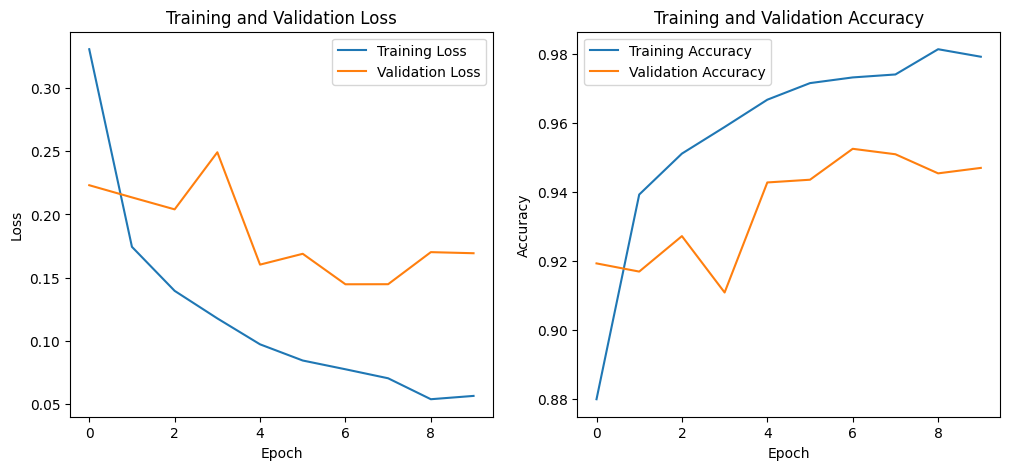

CPU times: user 1h 38min 17s, sys: 26.6 s, total: 1h 38min 43s
Wall time: 1h 17min 6s


In [9]:
%%time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained Vision Transformer model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = nn.Linear(model.classifier.in_features, 4)  # Modify the classifier layer
model.to(device)

# Define loss function and optimizer
LEARNING_RATE = 2e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
    return train_loss / len(train_loader), train_correct / len(train_loader.dataset)


# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


# Training and evaluation loop
num_epochs = 25
train_loss_values = []
train_acc_values = []

val_loss_values = []
val_acc_values = []

# Initialize variables to keep track of the best validation performance
best_val_loss = float('inf')
best_model_path = 'best_model.pth'
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
     # Store loss and accuracy values
    train_loss_values.append(train_loss)
    train_acc_values.append(train_accuracy)
    
    val_loss_values.append(val_loss)
    val_acc_values.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    
    # Save the model if the validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved the best model at epoch {epoch+1}')
        patience_counter = 0  # Reset the counter if we get a better result
    else:
        patience_counter += 1

    # Check if we have exceeded patience
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print('Loaded the best model from', best_model_path)

# Test Accuracy
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification report
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to device
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)
        all_targets.extend(targets.cpu().numpy())  
        all_predictions.extend(predicted.cpu().numpy())  

report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(report)


# Plotting the loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()